Выберите опцию:
1 - ЯМРК2 с постоянным шагом
2 - ЯМРК2 с переменным шагом
3 - Графики зависимости истинной полной погрешности от x
4 - Графики зависимости величины шага интегрирования от x 
5 - Графики зависимости отношения истинной локальной погрешности к полученной оценке локальной погрешности от x 
6 - Графики зависимости количества вычислений правой части от заданной точности eps 


Точные значения: y1_exact = 1.25664e-01, y2_exact = 2.09440e-01


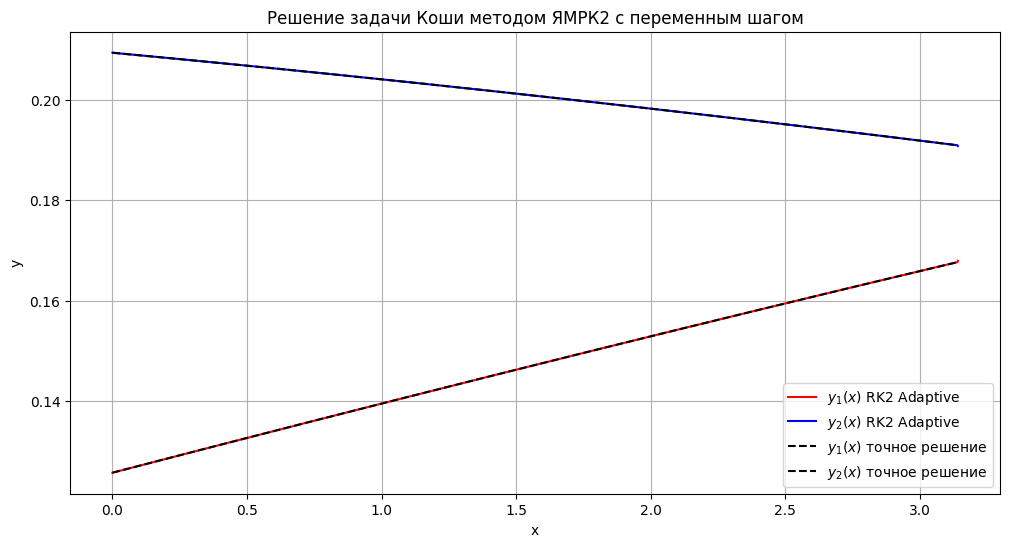

Некорректный выбор. Попробуйте снова.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint # source venv/bin/activate # python main.py

# === Константы и параметры ===
A = 1 / 12
B = 1 / 20 
pi = np.pi
c2 = 1 / 11
a21 = c2
b1 = 1 - 1 / (2 * c2)
b2 = 1 / (2 * c2)

# === Начальные данные ===
x0, x1 = 0.0, pi
y0 = [B * pi, A * pi]  # Начальное условие

def SODE(y, t, A, B):
    A = A
    B = B
    return np.array([A*y[1], -B*y[0]])

# === Функции ===
def f(x, y):
    """Правая часть системы дифференциальных уравнений."""
    return np.array([A * y[1], -B * y[0]])

# Метод Рунге-Кутты 2-го порядка
def runge_kutta_2(y0, num_steps, x_start, x_end):
    t = np.linspace(x_start, x_end, num_steps + 1)
    h = (x_end - x_start) / num_steps  # Шаг интегрирования
    y = np.zeros((num_steps + 1, 2))
    y[0] = y0
    
    for i in range(num_steps):
        k1 = h * f(t[i], y[i])
        k2 = h * f(t[i] + c2 * h, y[i] + a21 * k1)
        y[i + 1] = y[i] + b1 * k1 + b2 * k2
    
    return t, y

# Метод Рунге-Кутты 4-го порядка
def runge_kutta_4(y0, num_steps, x_start, x_end):
    t = np.linspace(x_start, x_end, num_steps)
    h = (x_end - x_start) / num_steps  # Шаг интегрирования
    y = np.zeros((num_steps + 1, 2))
    y[0] = y0
    
    for i in range(num_steps):
        k1 = h * f(t[i], y[i])
        k2 = h * f(t[i] + h / 2.0, y[i] + k1 / 2.0)
        k3 = h * f(t[i] + h / 2.0, y[i] + k2 / 2.0)
        k4 = h * f(t[i] + h, y[i] + k3)
        y[i + 1] = y[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6.
    
    return t, y

def full_error_runge_kutta(method, x0, x1, y0, h):
    """Оценка полной погрешности для метода Рунге-Кутты"""
    N1 = int((x1 - x0) / h)  # Число шагов для базового шага
    N2 = 2 * N1  # Число шагов для удвоенного шага

    # Вычисляем решения для шага h и h/2
    _, y_N1 = method(y0, N1, x0, x1)
    _, y_N2 = method(y0, N2, x0, x1)

    # Разница решений на последнем шаге
    R = np.abs(y_N1[-1] - y_N2[-1])
    return np.linalg.norm(R)

def first_step(eps):
    """Выбор начального шага для ЯМРК2."""
    delta = (1 / np.pi) ** 3 + max(A * np.pi, B * np.pi)
    h = (eps / delta) ** (1 / 3)
    return h
def solve_with_precision(x0, x1, y0, eps, method):
    """
    Решение задачи Коши с заданной точностью.
    """
    # Определяем начальный шаг с помощью first_step
    h = first_step(eps)
    max_iter = 1000  # Максимальное число итераций

    for i in range(max_iter):
        # Оценка полной погрешности для текущего шага
        error = full_error_runge_kutta(method, x0, x1, y0, h)
        
        if error < eps:  # Проверяем, достигается ли заданная точность
            break  # Если достигнута, выходим из цикла
        h /= 2  # Уменьшаем шаг вдвое

    if i == max_iter - 1:
        raise ValueError("Не удалось достичь заданной точности за максимальное число итераций.")
    
    print(f"Достигнута заданная точность eps = {eps:.1e} за {i + 1} итераций.")
    print(f"Используемый шаг интегрирования h = {h:.5e}")

    # Решение задачи Коши с найденным шагом
    num_steps = int((x1 - x0) / h)
    t, y = method(y0, num_steps, x0, x1)
    return t, y
import numpy as np

def solve_with_precision_2(y0, method):
    """
    Решение задачи Коши с заданной точностью для метода с переменным шагом.
    """
    # Начальное количество разбиений
    N1 = 1
    N2 = 2 * N1
    s = 2
    eps = 1e-5
    
    # Получение начальных результатов для разбиений N1 и N2
    _, res1_1 = method(y0, N1, x0, x1)
    _, res1_2 = method(y0, N2, x0, x1)
    
    # Получаем последние результаты на каждом шаге
    res1_1 = res1_1[N1]  # Последний элемент для N1
    res1_2 = res1_2[N2]  # Последний элемент для N2
    
    arr_res_1, arr_res_2 = [], []
    arr_res_1.append(res1_1)
    arr_res_2.append(res1_2)
    
    i, diff1, diffs1 = 1, 10, []
    
    # Итерационный процесс до достижения требуемой точности
    while diff1 >= eps:
        print(f'i: {i},\t diff1: {diff1}')
        
        # Получение новых результатов для разбиений N1 и N2
        _, res1_1 = method(y0, N1, x0, x1)
        _, res1_2 = method(y0, N2, x0, x1)
        
        # Получаем последние результаты
        res1_1 = res1_1[N1]
        res1_2 = res1_2[N2]
        
        # Оценка полной погрешности по Рунге
        diff1 = np.linalg.norm(np.array(res1_1) - np.array(res1_2)) / (1 - 2**(-s))
        diffs1.append(diff1)
        
        arr_res_1.append(res1_1)
        arr_res_2.append(res1_2)
        
        # Увеличиваем количество шагов
        N1 *= 2
        N2 = 2 * N1
        i += 1
    
    # Оптимальное число шагов
    N_opt = int(0.5 * N1)
    t_opt, res_opt = method(y0, N_opt, x0, x1)
    fmean = res_opt[N_opt]  # Последний результат для оптимального N
    # Точное решение для оценки погрешности
    nodes = np.linspace(x0, x1, N_opt + 1)
    sol = odeint(SODE, y0, nodes, args=(A, B))

    # Вычисление погрешности
    absolute_error = []
    for i in range(N_opt):
        error = max(abs(sol[i, 0] - res_opt[i][0]), abs(sol[i, 1] - res_opt[i][1]))
        absolute_error.append(error)
    
    # Итоговый результат
    print(f'Оптимальное число разбиений для постоянного шага: {N_opt}')
    print(f'Приближенное решение: {fmean}')
    print('Длина шага:', x1 / N_opt)
    print('Количество шагов:', N_opt)
    return N_opt, fmean, t_opt, absolute_error

def runge_kutta_adaptive(h_max, eps, method):
    h0 = first_step(eps)
    H = [h0]
    s = 2 if method == runge_kutta_2 else 4  # Порядок метода
    X, Y1, Y2, R = [x0], [y0[0]], [y0[1]], []

    # Начальные условия
    x_temp, y_temp, h_temp = x0, y0, h0

    # Вычисление локальной погрешности на первом шаге
    _, y_1step = method(y_temp, 1, x_temp, x_temp + h_temp)
    y_1step = y_1step[-1]
    _, y_2step = method(y_temp, 2, x_temp, x_temp + h_temp)
    y_2step = y_2step[-1]
    local_errorrate = max(
        abs((y_1step[0] - y_2step[0]) / (2**s - 1)),
        abs((y_1step[1] - y_2step[1]) / (2**s - 1))
    )
    R.append(local_errorrate)
    count = 2  # начальное число обращений
    # Истинная локальная погрешность на первом шаге
    true_local_error = []
    true_local_error.append(0)

    while x_temp < x1:
        # Истинная локальная погрешность (сравнение с точным решением)
        t = np.array([x_temp, x_temp + h_temp])
        sol = odeint(SODE, y_temp, t, args=(A, B))
        sol = sol[-1]
        true_local_error.append(np.linalg.norm(np.array(sol) - np.array(y_temp)))
        if local_errorrate > eps * 2**s:  # Погрешность превышает допустимую, уменьшаем шаг
            h_temp /= 2
            H.append(h_temp)
            count += 5

        elif eps < local_errorrate <= eps * 2**s:  
            h_temp = h_temp / 2
            H.append(h_temp)
            x_temp += h_temp
            _, y_temp = method(y_temp, 2, x_temp, x_temp + h_temp)
            y_temp = y_temp[-1]
            count += 6

        elif 1 / (2**(s + 1)) * eps <= local_errorrate <= eps:  
            H.append(h_temp)
            x_temp += h_temp
            _, y_temp = method(y_temp, 1, x_temp, x_temp + h_temp)
            y_temp = y_temp[-1]
            count += 6

        elif local_errorrate < 1 / (2**(s + 1)) * eps:  # Погрешность слишком мала, увеличиваем шаг
            h_temp = min(2 * h_temp, h_max)
            H.append(h_temp)
            x_temp += h_temp
            _, y_temp = method(y_temp, 1, x_temp, x_temp + h_temp)
            y_temp = y_temp[-1]
            count += 6
        if x_temp > x1:
            h_temp = abs(x_temp - h_temp - x1)  # Корректируем шаг, чтобы он не выходил за x1
            x_temp = x1  # Устанавливаем x_temp в x1
            H.append(h_temp)
            # Проводим последние вычисления для корректного завершения на x1
            _, y_temp = method(y_temp, 1, x_temp, x_temp + h_temp)
            y_temp = y_temp[-1]
            count += 6
        
        _, y_1step = method(y_temp, 1, x_temp, x_temp + h_temp)
        y_1step = y_1step[-1]
        _, y_2step = method(y_temp, 2, x_temp, x_temp + h_temp)
        y_2step = y_2step[-1]
        local_errorrate = max(
            abs((y_1step[0] - y_2step[0]) / (2**s - 1)),
            abs((y_1step[1] - y_2step[1]) / (2**s - 1))
        )
        X.append(x_temp)
        Y1.append(y_temp[0])
        Y2.append(y_temp[1])
        R.append(local_errorrate)

    return np.array(X),np.array(Y1), np.array(Y2), np.array(H), count, np.array(R), np.array(true_local_error)



def main():
    print("Выберите опцию:")
    print("1 - ЯМРК2 с постоянным шагом")
    print("2 - ЯМРК2 с переменным шагом")
    print("3 - Графики зависимости истинной полной погрешности от x")
    print("4 - Графики зависимости величины шага интегрирования от x ")
    print("5 - Графики зависимости отношения истинной локальной погрешности к полученной оценке локальной погрешности от x ")
    print("6 - Графики зависимости количества вычислений правой части от заданной точности eps ")
    
    choice = input("Введите ваш выбор: ")
    
    if choice == "1":
        eps = 1e-4  # Заданная точность
        t, y = solve_with_precision(x0, x1, y0, eps, runge_kutta_2)
        
        # Решение с использованием odeint (точное решение)
        nodes = np.linspace(x0, x1, 1000)
        sol = odeint(SODE, y0, nodes, args=(A, B))

        # === Построение графиков ===
        plt.figure(figsize=(12, 6))

        # Приближенные решения методом Рунге-Кутты 2-го порядка
        plt.plot(t, y[:, 0], label='$y_1(x)$ RK2', color='red')
        plt.plot(t, y[:, 1], label='$y_2(x)$ RK2', color='blue')

        # Точные решения
        plt.plot(nodes, sol[:, 0], label='$y_1(x)$ точное решение', color='black', linestyle='--')
        plt.plot(nodes, sol[:, 1], label='$y_2(x)$ точное решение', color='black', linestyle='--')

        plt.title('Решение задачи Коши с заданной точностью')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid()
        plt.show()
    elif choice == "2":
        eps = 1e-5
        # Распаковка значений, которые возвращает метод runge_kutta_adaptive
        t, y1, y2, _, _ , _, _= runge_kutta_adaptive(0.02, eps, runge_kutta_2)

        # Точные значения для t ≈ 3.14159
        t_exact = np.pi  # Конечная точка интервала
        sol = odeint(SODE, y0, [t_exact], args=(A, B))

        y1_exact_value = sol[0, 0]
        y2_exact_value = sol[0, 1]
        print(f"Точные значения: y1_exact = {y1_exact_value:.5e}, y2_exact = {y2_exact_value:.5e}")

        # === Построение графиков ===
        nodes = np.linspace(x0, x1, 1000)
        sol = odeint(SODE, y0, nodes, args=(A, B))

        plt.figure(figsize=(12, 6))

        # Приближенные решения методом Рунге-Кутты 2-го порядка с переменным шагом
        plt.plot(t, y1, label='$y_1(x)$ RK2 Adaptive', color='red')
        plt.plot(t, y2, label='$y_2(x)$ RK2 Adaptive', color='blue')

        # Точные решения
        plt.plot(nodes, sol[:, 0], label='$y_1(x)$ точное решение', color='black', linestyle='--')
        plt.plot(nodes, sol[:, 1], label='$y_2(x)$ точное решение', color='black', linestyle='--')

        plt.title('Решение задачи Коши методом ЯМРК2 с переменным шагом')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid()
        plt.show()

    if choice == "3":
        # Построение графиков истинной полной погрешности
        N_opt2, _, _, error_rk2 = solve_with_precision_2(y0, runge_kutta_2)
        N_opt4, _, _, error_rk4 = solve_with_precision_2(y0, runge_kutta_4)

        # Обратите внимание на количество точек в nodes, error_rk2 и error_rk4
        nodes_rk2 = np.linspace(x0, x1, N_opt2 + 1)
        nodes_rk4 = np.linspace(x0, x1, N_opt4 + 1)
        
        # Построение графиков
        plt.figure(figsize=(10, 6))
        
        # График для Рунге-Кутты 2-го порядка
        plt.plot(nodes_rk2[:len(error_rk2)], error_rk2, label="Ошибка Рунге-Кутты 2-го порядка", color='blue')
        
        # График для Рунге-Кутты 4-го порядка
        plt.plot(nodes_rk4[:len(error_rk4)], error_rk4, label="Ошибка Рунге-Кутты 4-го порядка", color='red')
        
        # Настройки графика
        plt.title("Истинная полная погрешность от x")
        plt.xlabel("x")
        plt.ylabel("Полная погрешность")
        plt.legend()
        plt.grid(True)
        plt.show()

    elif choice == "4":
        # Параметры
        eps = 1e-9

        # Решение с адаптивным шагом для ЯМРК 2
        _, _, _, H_rk2, _, _, _ = runge_kutta_adaptive(0.2, eps, runge_kutta_2)
        # Решение с адаптивным шагом для ЯМРК 4
        _, _, _, H_rk4, _, _, _ = runge_kutta_adaptive(0.2, eps, runge_kutta_4)
        # Создание одного окна для графиков
        plt.figure(figsize=(12, 6))

        # Подграфик 1 - ЯМРК 2
        plt.subplot(1, 2, 1)  # 1 ряд, 2 колонки, первый подграфик
        plt.plot(np.linspace(x0, x1, len(H_rk2)), H_rk2, label="Шаг интегрирования для ЯМРК 2", color='red')
        plt.title('Зависимость величины шага интегрирования от $x$ для ЯМРК 2')
        plt.xlabel('$x$')
        plt.ylabel('Шаг интегрирования $h$')
        plt.grid()
        plt.legend()

        # Подграфик 2 - ЯМРК 4
        plt.subplot(1, 2, 2)  # 1 ряд, 2 колонки, второй подграфик
        plt.plot(np.linspace(x0, x1, len(H_rk4)), H_rk4, label="Шаг интегрирования для ЯМРК 4", color='blue')
        plt.title('Зависимость величины шага интегрирования от $x$ для ЯМРК 4')
        plt.xlabel('$x$')
        plt.ylabel('Шаг интегрирования $h$')
        plt.grid()
        plt.legend()

        # Показать оба графика
        plt.tight_layout()  # Для лучшего расположения подграфиков
        plt.show()
    elif choice == "5":
        eps = 1e-5
        # Вызываем функцию для ЯМРК2
        X_rk2, Y1_rk2, Y2_rk2, H_rk2, count_rk2, R_rk2, true_local_error_rk2 = runge_kutta_adaptive(0.1, eps, runge_kutta_2)

        # Вызываем функцию для ЯМРК4
        X_rk4, Y1_rk4, Y2_rk4, H_rk4, count_rk4, R_rk4, true_local_error_rk4 = runge_kutta_adaptive(0.1, eps, runge_kutta_4)

        # Создаем одно окно с двумя подграфиками
        fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # 2 строки, 1 столбец для подграфиков

        # График для ЯМРК2
        ratio_rk2 = np.array(true_local_error_rk2) / np.array(R_rk2)
        axes[0].plot(X_rk2, ratio_rk2, label="ЯМРК2")
        axes[0].set_xlabel('x')
        axes[0].set_title('ЯМРК2: Отношение истинной локальной погрешности к оценке')
        axes[0].legend()
        axes[0].grid(True)

        # График для ЯМРК4
        ratio_rk4 = np.array(true_local_error_rk4) / np.array(R_rk4)
        axes[1].plot(X_rk4, ratio_rk4, label="ЯМРК4")
        axes[1].set_xlabel('x')
        axes[1].set_title('ЯМРК4: Отношение истинной локальной погрешности к оценке')
        axes[1].legend()
        axes[1].grid(True)

        # Показать оба графика в одном окне
        plt.tight_layout()
        plt.show()
    elif choice == "6":
        # Параметры для эксперимента
        eps_values = [1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
        counts2 = []  # Список для хранения количества обращений для ЯМРК 2
        counts4 = []  # Список для хранения количества обращений для ЯМРК 4
        
        # Для каждого значения eps выполняем расчет для ЯМРК 2
        for eps in eps_values:
            _, _, _, _, count2, _, _ = runge_kutta_adaptive(0.02, eps, runge_kutta_2)
            counts2.append(count2)
            _, _, _, _, count4, _, _ = runge_kutta_adaptive(0.02, eps, runge_kutta_4)
            counts4.append(count4)
        # Создаем подграфы
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 строка, 2 столбца

        # График для ЯМРК 2
        ax1.plot(eps_values, counts2, 'o-', label='ЯМРК 2', color='b')  # 'o-' означает точки, соединенные линией
        ax1.set_title(r'Зависимость числа обращений к правой части от $\varepsilon$ (ЯМРК 2)', fontsize=14)
        ax1.set_xlabel(r'$\varepsilon$', fontsize=12)
        ax1.set_ylabel('Количество обращений', fontsize=12)
        ax1.set_xscale('log')  # Логарифмическая шкала для оси X
        ax1.grid(True)
        ax1.legend()

        # График для Оппонента (ЯМРК 4)
        ax2.plot(eps_values, counts4, 'o-', label='Оппонент (ЯМРК 4)', color='r')  # 'o-' означает точки, соединенные линией
        ax2.set_title(r'Зависимость числа обращений к правой части от $\varepsilon$ (Оппонент)', fontsize=14)
        ax2.set_xlabel(r'$\varepsilon$', fontsize=12)
        ax2.set_ylabel('Количество обращений', fontsize=12)
        ax2.set_xscale('log')  # Логарифмическая шкала для оси X
        ax2.grid(True)
        ax2.legend()
        # Отображаем графики
        plt.tight_layout()  # Улучшает компоновку подграфов
        plt.show()
        
    else:
         print("Некорректный выбор. Попробуйте снова.")

# Запуск программы
if __name__ == "__main__":
    main()